In [50]:
## Import necessary libraries
# rioxarray extends xarray to understand geospatial rasters (GeoTIFF, NetCDF…)
import numpy as np
import rasterio
from rasterio.transform import from_origin
import rioxarray as rxr
# from rasterio.enums import Resampling
import rasterio
# import rasterio.plot
import netCDF4 as nc
import numpy as np
import geojson as gj
import pandas as pd
import geopandas as gpd
from affine import Affine
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import FormatStrFormatter
import datetime
print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

2025-09-14 16:02:43


## Loading the GeoTiff data

In [2]:

'''
Your data.tif

F002 - Mission 
L1 - Level 1 processing
IR - Infrared
L2L1M0 - Level 2 processing, Level 1 data, Mode 0
2025-01-10T215412.018348Z - Start time of data acquisition
2025-04-10T154832.806087Z - End time of data acquisition
97706189 - Unique identifier for the data file
MWIR - Mid-Wave Infrared band

'''

### Analogus to fits files stored in a directory loading the GeoTiFF file
# Open a GeoTIFF file with rioxarray


da = rxr.open_rasterio("Dataset_1/your_data.tif").squeeze() # Remove the band dimension if it's single-band
print("Original coordinate reference system:", da.rio.crs) # Coordinate Reference System
print("Original resolution:", da.rio.resolution()) # (pixel width, pixel height)
print("Original bounds:", da.rio.bounds()) # (left, bottom, right, top) in the CRS units
print("Original shape:", da.shape) # (height, width)

print()

Original coordinate reference system: EPSG:4326
Original resolution: (0.0021542764927380328, -0.0018038813559322039)
Original bounds: (-120.64174, 30.317300000000003, -116.63693999999998, 36.70304)
Original shape: (3540, 1859)



In [3]:
# Another way to load data
path = "Dataset_1/your_data.tif"

with rasterio.open(path) as ds:
    print("CRS:", ds.crs)
    print("Resolution:", ds.res)
    print("Bounds:", ds.bounds)
    print("Dtypes:", ds.dtypes)                 # per-band dtype
    print("Nodata:", ds.nodatavals)             # per-band NoData
    print("Descriptions:", ds.descriptions)     # per-band descriptions (names)
    print("Global tags:", ds.tags())            # file-level tags/metadata
    print("Band-1 tags:", ds.tags(1))           # band-level tags (often where units live)
    print("Scales:", ds.scales)                 # scale_factor (if any)
    print("Offsets:", ds.offsets)               # add_offset (if any)
    print("Profile:", ds.profile)               # compact summary


with rasterio.open(path) as ds:
    print("Number of bands:", ds.count)        # how many channels
    print("Descriptions:", ds.descriptions)    # names/labels of each band
    for i in range(1, ds.count + 1):
        print(f"Band {i} dtype:", ds.dtypes[i-1])
        print(f"Band {i} tags:", ds.tags(i))   # metadata per band


CRS: EPSG:4326
Resolution: (0.0021542764927380328, 0.0018038813559322039)
Bounds: BoundingBox(left=-120.64174, bottom=30.3173, right=-116.63694, top=36.70304)
Dtypes: ('float32',)
Nodata: (-3.4028234663852886e+38,)
Descriptions: (None,)
Global tags: {'AREA_OR_POINT': 'Area'}
Band-1 tags: {}
Scales: (1.0,)
Offsets: (0.0,)
Profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 1859, 'height': 3540, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.0021542764927380328, 0.0, -120.64174,
       0.0, -0.0018038813559322039, 36.70304), 'blockxsize': 1859, 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
Number of bands: 1
Descriptions: (None,)


Data range before masking: -3.4028234663852886e+38 to 2.1434011459350586


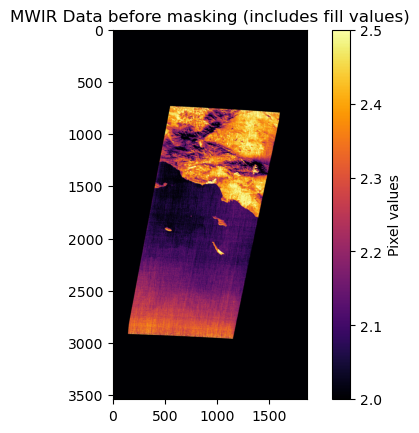

In [25]:
# This shows all pixel values, including invalid NoData fill values (huge negatives).
arr_pre_mask = da.values

lo, hi = np.nanpercentile(arr_pre_mask, 1), np.nanpercentile(arr_pre_mask, 80)

print(f"Data range before masking: {lo} to {hi}")
plt.imshow(da.values, cmap="inferno",vmin=2, vmax=2.5) # Units are W/m^2/sr/um for radiance
plt.colorbar(label="Pixel values")
plt.title("MWIR Data before masking (includes fill values)")

plt.savefig("Plots/Dataset_1/MWIR_Data_before_masking.png", dpi=300)

In [5]:
## As the mask value is already applied to the data set at -3.4e38 we can use this to mask out the invalid values

# Mask out NoData and non-finite values
da_clean = da.where(np.isfinite(da) & (da != da.rio.nodata))

# Optional: mask negative radiance (physically invalid)
da_clean = da_clean.where(da_clean >= 0)

arr = da_clean.values
print("Shape:", arr.shape)
print("Min:", np.nanmin(arr))
print("P02:", np.nanpercentile(arr, 2))
print("Median:", np.nanmedian(arr))
print("P98:", np.nanpercentile(arr, 98))
print("Max:", np.nanmax(arr))
print("NaN fraction:", np.mean(~np.isfinite(arr)))
print("Units:", da.attrs.get("units"))




Shape: (3540, 1859)
Min: 1.6912485
P02: 1.9787518
Median: 2.1793933
P98: 2.490269
Max: 65.1618
NaN fraction: 0.6562666581571406
Units: None


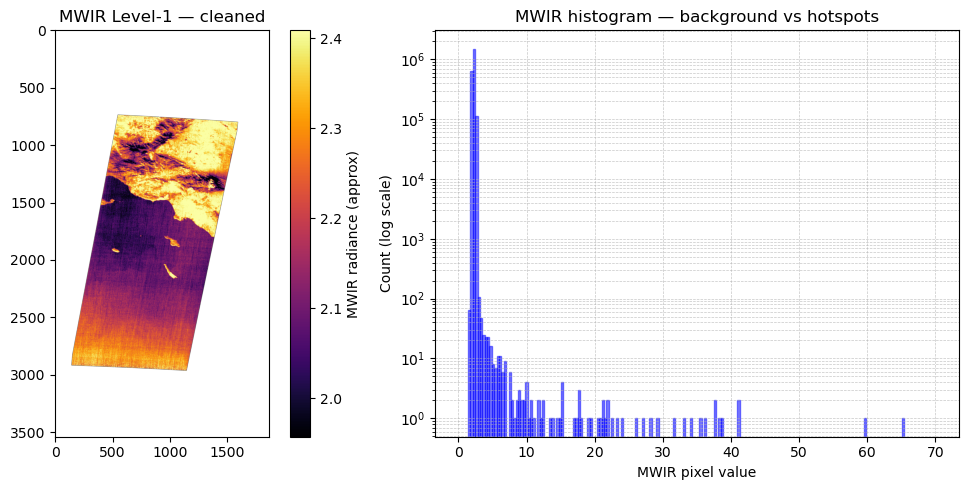

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Percentile stretch for background detail
lo, hi = np.nanpercentile(arr, 1), np.nanpercentile(arr, 90)

# Create side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Plot 1: MWIR image (robust stretch) ---
im = axes[0].imshow(arr, vmin=lo, vmax=hi, cmap="inferno")
cbar = plt.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
cbar.set_label("MWIR radiance (approx)", fontsize=10)

axes[0].set_title("MWIR Level-1 — cleaned", fontsize=12, loc="center")
axes[0].axis("on")  # cleaner without axes

# --- Plot 2: Histogram ---
vals = arr[np.isfinite(arr)]
axes[1].hist(vals, bins=200, log=True, range=(0, 70), color="Blue", edgecolor="blue",alpha = 0.5)
axes[1].set_xlabel("MWIR pixel value", fontsize=10)
axes[1].set_ylabel("Count (log scale)", fontsize=10)
axes[1].set_title("MWIR histogram — background vs hotspots", fontsize=12, loc="center")
axes[1].grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)


# Tidy layout
plt.tight_layout()
plt.savefig("Plots/Dataset_1/MWIR_combined.png", dpi=300,bbox_inches='tight')
plt.show()


In [7]:
print(np.where(np.nanmax(arr) == arr)) # Find the location of the maximum value in the array
print(arr[1400:1500,800:1000]) # Find the pixel values around the maximum value

(array([1433]), array([977]))
[[2.3250415 2.3384235 2.3813252 ... 2.257323  2.296748  2.3198588]
 [2.3106687 2.3089685 2.3779438 ... 2.304082  2.2898436 2.3348515]
 [2.3139813 2.3313086 2.3498178 ... 2.3692565 2.322798  2.351485 ]
 ...
 [2.1074908 1.9990318 1.967031  ... 2.1628873 2.2028856 2.3389187]
 [2.0923626 2.0082045 1.9967157 ... 2.1413987 2.2245774 2.3248794]
 [2.0321326 2.0212743 2.0700092 ... 2.13876   2.1511815 2.231243 ]]


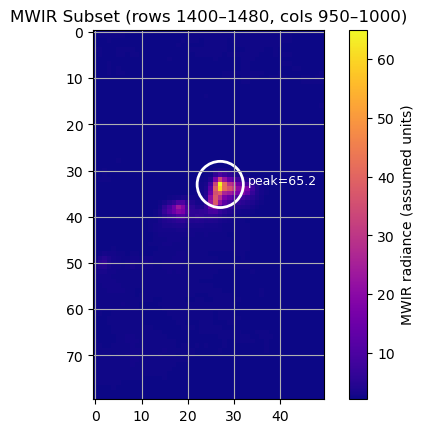

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Existing subset + stretch
sub_arr = arr[1400:1480, 950:1000]
lo, hi = np.nanpercentile(sub_arr, 1), np.nanpercentile(sub_arr, 99.999)

# Find brightest pixel (row r, col c) to plot a circle around
r, c = np.unravel_index(np.nanargmax(sub_arr), sub_arr.shape)

fig, ax = plt.subplots()
im = ax.imshow(sub_arr, vmin=lo, vmax=hi, cmap="plasma")
plt.colorbar(im, ax=ax, label="MWIR radiance (assumed units)")
ax.set_title("MWIR Subset (rows 1400–1480, cols 950–1000)")

# Draw a circle (tweak radius if needed)
ax.add_patch(Circle((c, r), radius=5, fill=False, edgecolor="white", linewidth=2))
ax.annotate(f"peak={sub_arr[r, c]:.1f}", (c+6, r), color="white", fontsize=9)
plt.grid()
plt.savefig("Plots/Dataset_1/MWIR_Zoomed.png", dpi=300,bbox_inches='tight')
plt.show()


## Load the geojson data

In [47]:
# --- Load detections from GeoJSON ---
# Contains candidate detection points (e.g., hotspots). 
# Each detection has geographic coordinates in the file’s CRS.
gdf = gpd.read_file(
    "Dataset_1/Your_data.geojson"
)

# Reproject detections to the raster’s CRS so both are aligned
# (da.rio.crs is the CRS of the raster opened with rioxarray).
gdf = gdf.to_crs(da.rio.crs)  
print(gdf.head(160))


# --- Map world coordinates → pixel indices (col, row) ---
# The raster stores data in a grid. We need to map each detection’s (x,y) position 
# into grid indices so we can extract raster values underneath them.

A = da.rio.transform()  
# Affine transformation matrix from raster metadata. 
# It defines the mapping: (col,row) → (x,y) in world coordinates.

A = Affine(*A[:6]) if not isinstance(A, Affine) else A   # 2D affine described by 6 parameters
# Ensure we have a proper Affine object.
# Affine encodes transforms of the form:
#   x = A*col + B*row + C
#   y = D*col + E*row + F

# Invert the transform: now we can map (x,y) → (col,row).
# This is what we need to find the pixel each detection falls into.

Ainv = ~A  

# Print few world coordinates
print("Geometric x and y values = ", gdf.geometry.x.values[:5], gdf.geometry.y.values[:5])

# --- Convert detection coordinates to pixel indices ---
# Apply inverse affine transform to get fractional (col, row) positions.
cols, rows = Ainv * (gdf.geometry.x.values, gdf.geometry.y.values)
print("Sample cols, rows:", cols[:5], rows[:5])

# Round to nearest integer pixel indices.
# NOTE: rows = y-direction (height), cols = x-direction (width).
cols = np.round(cols).astype(int)
rows = np.round(rows).astype(int)


# --- Clip to valid raster bounds ---
H, W = arr.shape
ok = (rows >= 0) & (rows < H) & (cols >= 0) & (cols < W)

# Assign row/col values; invalid indices → -1.
gdf["row"] = np.where(ok, rows, -1)
gdf["col"] = np.where(ok, cols, -1)


# Extract raster MWIR values at those pixel indices
# If detection falls outside raster, assign NaN.
gdf["mwir_val"] = np.where(ok, arr[rows[ok], cols[ok]], np.nan)



# --- Output ---
print()
print("Total detections:", len(gdf))
print(gdf[["row", "col", "mwir_val"]].head())
print("Valid MWIR detections:", gdf["mwir_val"].notna().sum())


           lat        lon                     geometry
0    33.612656 -117.82159  POINT (-117.82159 33.61266)
1    34.227455 -118.09740   POINT (-118.0974 34.22746)
2    34.225689 -118.09784  POINT (-118.09784 34.22569)
3    34.227821 -118.09953  POINT (-118.09953 34.22782)
4    34.226055 -118.09997  POINT (-118.09997 34.22606)
..         ...        ...                          ...
155  34.332001 -119.61788    POINT (-119.61788 34.332)
156  34.289513 -119.62762  POINT (-119.62762 34.28951)
157  34.268265 -119.63248  POINT (-119.63248 34.26826)
158  32.537846 -120.02183  POINT (-120.02183 32.53785)
159  32.116417 -120.11684  POINT (-120.11684 32.11642)

[160 rows x 3 columns]
Geometric x and y values =  [-117.82159424 -118.09740448 -118.09783936 -118.09952545 -118.09996796] [33.61265564 34.22745514 34.22568893 34.22782135 34.22605515]
Sample cols, rows: [1309.09183256 1181.06265774 1180.8607916  1180.0781176  1179.87270994] [1713.18604197 1372.36567843 1373.34479207 1372.16266567 1373.1

1. [Data Base for maps of southern california](https://databasin.org/maps/new/#datasets=3fac6542263d4972af2f55dc13737f36)

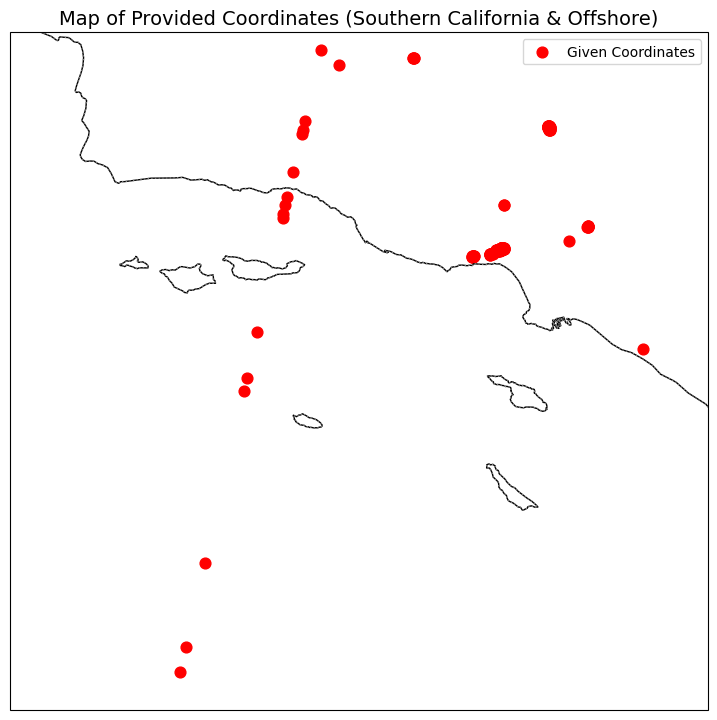

In [10]:


# Extract lat/lon separately from the GeoDataFrame
lons = gdf.geometry.x.values
lats = gdf.geometry.y.values

# Plot map using Cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(figsize=(9,9), subplot_kw={'projection': ccrs.PlateCarree()})

# Add coastlines and borders
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor="gray")

# Scatter points
ax.scatter(lons, lats, color="red", s=60, transform=ccrs.PlateCarree(), label="Given Coordinates")

# Set extent to Southern California region
ax.set_extent([-121, -117.5, 31.8, 35.2], crs=ccrs.PlateCarree()) # 

ax.set_title("Map of Provided Coordinates (Southern California & Offshore)", fontsize=14) # as given in json file
ax.legend()
plt.show()


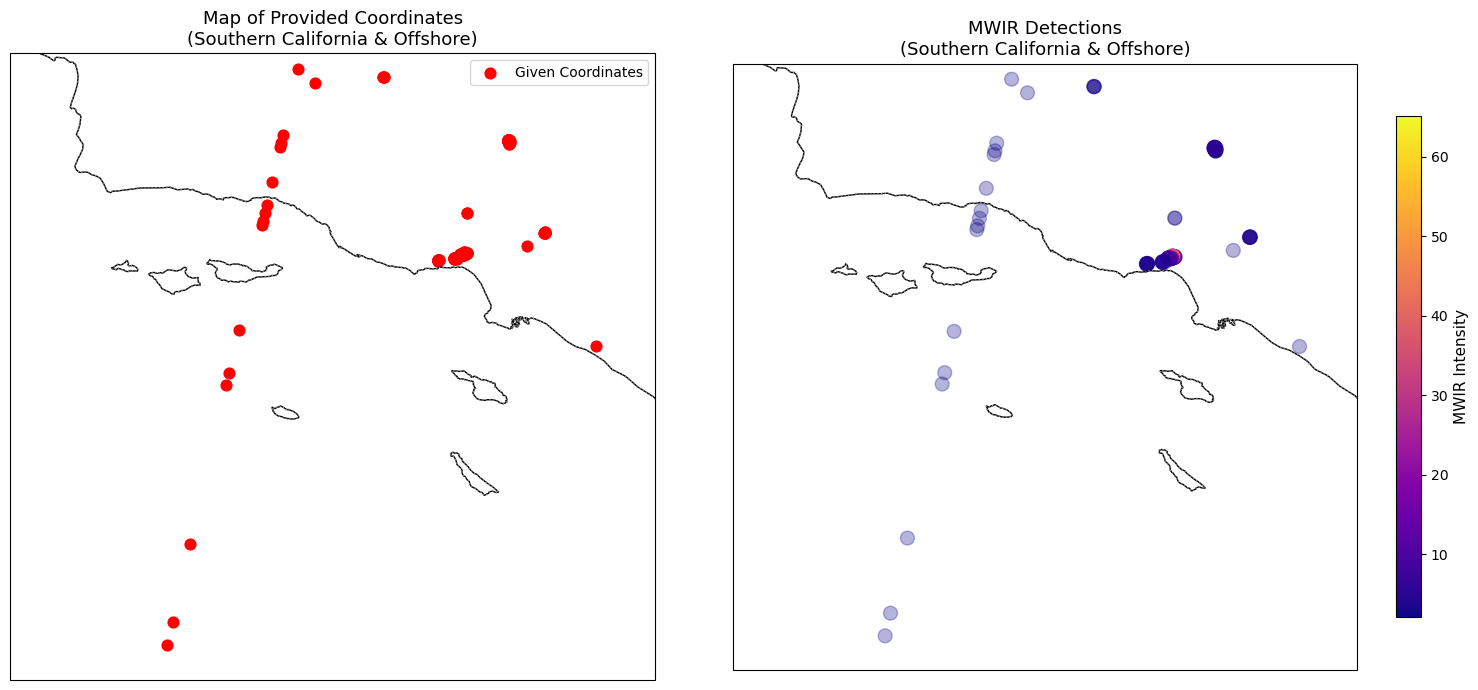

In [49]:


# ------------------------------------------------------------
# Extract coordinates and MWIR values from the GeoDataFrame
# ------------------------------------------------------------
lons = gdf.geometry.x.values
lats = gdf.geometry.y.values
mwir_vals = gdf["mwir_val"].values

# ------------------------------------------------------------
# Normalize MWIR values to scale transparency (alpha)
# Ensures faint background detections are visible but strong
# hotspots stand out more clearly
# ------------------------------------------------------------
norm = (mwir_vals - mwir_vals.min()) / (mwir_vals.max() - mwir_vals.min())
alphas = 0.3 + 0.7 * norm   # alpha in [0.3, 1.0]

# ------------------------------------------------------------
# Create side-by-side figure with two Cartopy maps
# ------------------------------------------------------------
fig, axes = plt.subplots(
    1, 2, figsize=(16, 7), subplot_kw={'projection': ccrs.PlateCarree()}
)

# ============================================================
# LEFT PANEL: Raw coordinate scatter (all detections in red)
# ============================================================
ax = axes[0]
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor="gray")

# Plot points (red, fixed size)
ax.scatter(
    lons, lats, 
    color="red", s=60,
    transform=ccrs.PlateCarree(),
    label="Given Coordinates"
)

# Zoom in on Southern California & offshore
ax.set_extent([-121, -117.5, 31.8, 35.2], crs=ccrs.PlateCarree())

ax.set_title("Map of Provided Coordinates\n(Southern California & Offshore)",
             fontsize=13, loc="center")
ax.legend()

# ============================================================
# RIGHT PANEL: MWIR detections (colored by intensity)
# ============================================================
ax = axes[1]
ax.coastlines(resolution="10m")
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':', edgecolor="gray")

# Scatter points, colored by MWIR value + transparency scaled
sc = ax.scatter(
    lons, lats, 
    c=mwir_vals, cmap="plasma",    
    s=100, alpha=alphas,
    transform=ccrs.PlateCarree()
)

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.8, pad=0.05)
cbar.set_label("MWIR Intensity", fontsize=11)

# Same region extent
ax.set_extent([-121, -117.5, 31.8, 35.2], crs=ccrs.PlateCarree())

ax.set_title("MWIR Detections\n(Southern California & Offshore)",
             fontsize=13, loc="center")

# ------------------------------------------------------------
# Save and show the combined figure
# ------------------------------------------------------------
plt.tight_layout()
plt.savefig("Plots/Dataset_1/Coordinates_vs_MWIR.png", dpi=300, bbox_inches="tight")
plt.show()


      row  col   mwir_val
46   1434  985   4.304351
47   1435  984   6.731573
48   1436  984   4.708745
49   1433  984   6.007771
50   1434  983  17.616779
..    ...  ...        ...
120  1451  952   4.480877
121  1452  952   3.220232
122  1450  952   5.880688
123  1450  951   5.179708
124  1451  951   4.371436

[77 rows x 3 columns]


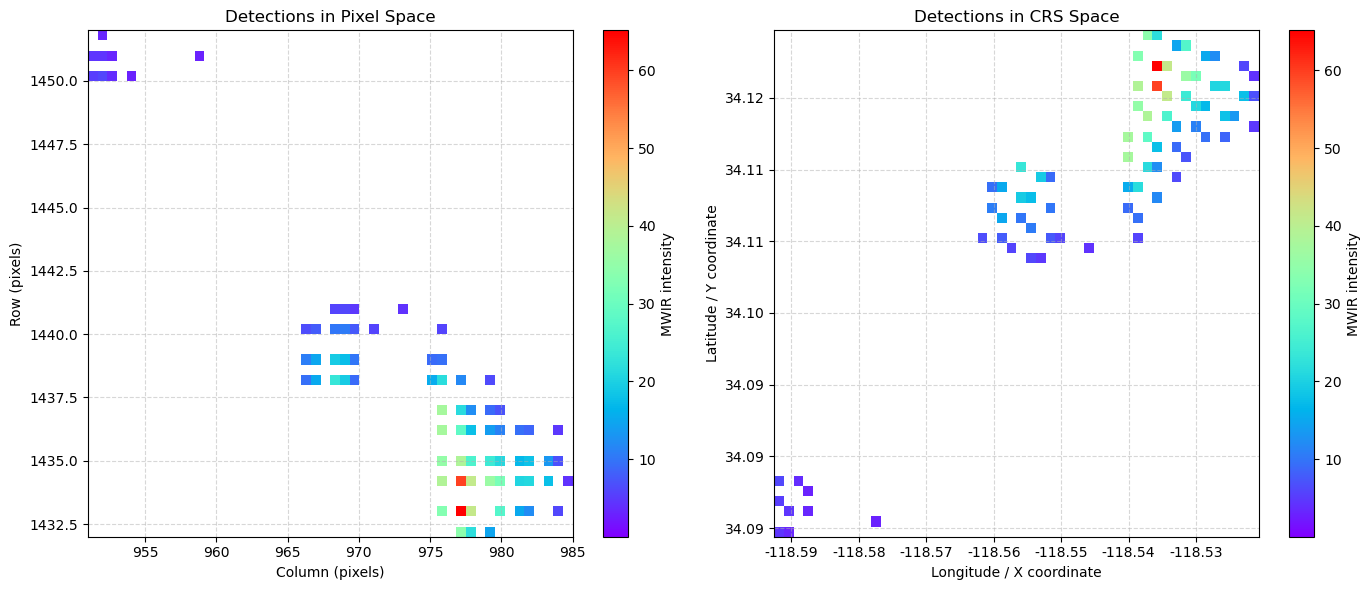

In [54]:

row_min, row_max = 1400, 1480
col_min, col_max = 950, 1000


# Create a mask for detections inside this window
inside = (
    (gdf["row"] >= row_min) & (gdf["row"] < row_max) &
    (gdf["col"] >= col_min) & (gdf["col"] < col_max)
)


# Filter GeoDataFrame
gdf_sub = gdf[inside].copy()


# Print detections in this subwindow with their MWIR values
print(gdf_sub[["row", "col", "mwir_val"]])


row_pix = gdf_sub["row"]
col_pix = gdf_sub["col"]
mwir_vals = gdf_sub["mwir_val"]


# Extract data
row_pix = gdf_sub["row"].values # pixel row indices (y-axis in raster)
col_pix = gdf_sub["col"].values # pixel col indices (y-axis in raster)
x = gdf_sub.geometry.x.values   # ongitude in degrees (EPSG:4326)
y = gdf_sub.geometry.y.values   # latitude in degrees (EPSG:4326)
mwir_vals = gdf_sub["mwir_val"].values

# --- Colormap setup ---
# Copy rainbow colormap and force values below vmin to show as white
cmap = plt.cm.rainbow.copy()
cmap.set_under("white")

# --- Create side-by-side plots ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# =====================================================
# Left panel: Pixel space
# =====================================================
hist1 = axes[0].hist2d(
    col_pix, row_pix,
    weights=mwir_vals,
    bins=(50, 50),
    cmap=cmap,
    vmin=0.01
)
fig.colorbar(hist1[3], ax=axes[0], label="MWIR intensity")
axes[0].set_xlabel("Column (pixels)")
axes[0].set_ylabel("Row (pixels)")
axes[0].set_title("Detections in Pixel Space")
axes[0].ticklabel_format(style="plain")
axes[0].grid(True, linestyle="--", alpha=0.5)  # add grid overlay


# =====================================================
# Right panel: Geographic space (lon/lat)
# =====================================================

# --- Right: Geographic / CRS space ---
hist2 = axes[1].hist2d(
    x, y,
    weights=mwir_vals,
    bins=(50, 50),
    cmap=cmap,
    vmin=0.01
)
fig.colorbar(hist2[3], ax=axes[1], label="MWIR intensity")
axes[1].set_xlabel("Longitude / X coordinate")
axes[1].set_ylabel("Latitude / Y coordinate")
axes[1].set_title("Detections in CRS Space")
axes[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axes[1].grid(True, linestyle="--", alpha=0.5)  # add grid overlay

plt.tight_layout()
plt.show()


/Users/user/miniconda3/envs/geoenv/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:379: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/var/folders/hf/vz4h4wks33b6j2lhgdccrv680000gp/T/ipykernel_41083/122816106.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


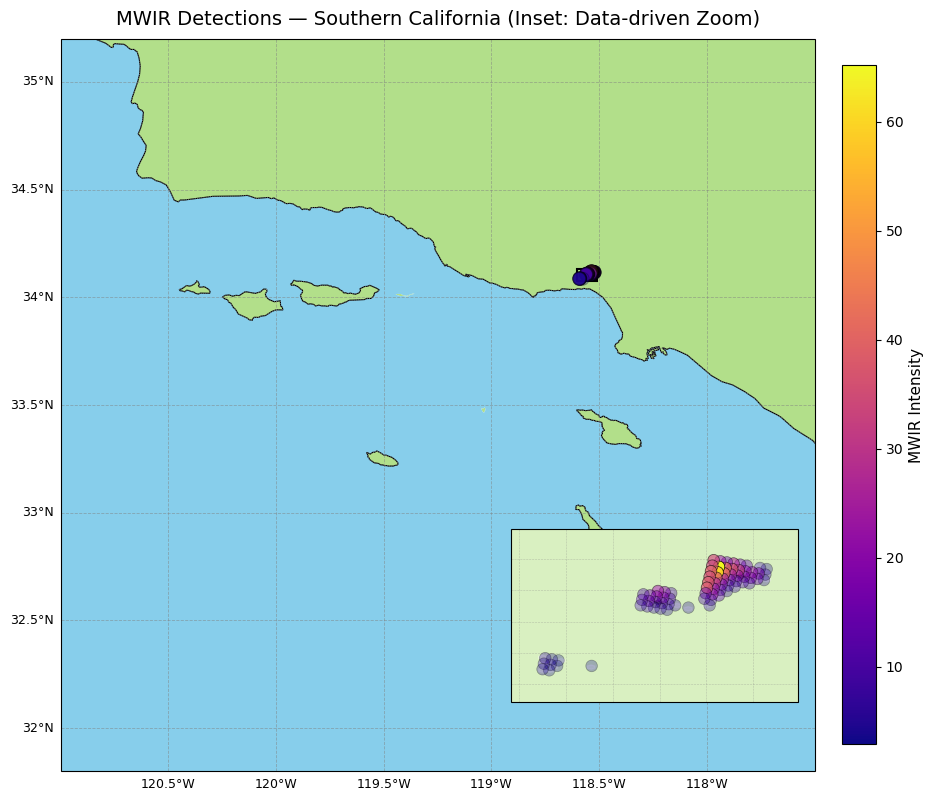

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# --- Data ---
lons = gdf_sub.geometry.x.values
lats = gdf_sub.geometry.y.values
mwir_vals = gdf_sub["mwir_val"].values

# --- Data-driven zoom bounds (for the inset) ---
pad = 0.01  # degrees
lon_min, lon_max = float(np.nanmin(lons) - pad), float(np.nanmax(lons) + pad)
lat_min, lat_max = float(np.nanmin(lats) - pad), float(np.nanmax(lats) + pad)

# --- Alpha scaling ---
mv_min, mv_max = np.nanmin(mwir_vals), np.nanmax(mwir_vals)
if not np.isfinite(mv_max - mv_min) or (mv_max - mv_min) == 0:
    alphas = np.full_like(mwir_vals, 0.7, dtype=float)
else:
    norm = (mwir_vals - mv_min) / (mv_max - mv_min + 1e-12)
    alphas = 0.3 + 0.7 * np.clip(norm, 0, 1)

# --- Figure & MAIN AXES ---
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': proj})

# Basemap
ax.add_feature(cfeature.LAND, facecolor="#b2df8a")
ax.add_feature(cfeature.OCEAN, facecolor="#87CEEB")
ax.coastlines(resolution="10m", linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.7, edgecolor="#666666")
ax.add_feature(cfeature.STATES, linestyle=":", edgecolor="#888888", linewidth=0.6)

# Optional density underlay
hb = ax.hexbin(
    lons, lats, gridsize=40, bins="log", mincnt=1,
    transform=proj, cmap="Greys", alpha=0.5
)

# Points
sc = ax.scatter(
    lons, lats, c=mwir_vals, cmap="plasma",
    s=90, linewidths=0.6, edgecolors="k",
    alpha=alphas, transform=proj, zorder=5
)

# Colorbar
cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.7, pad=0.03)
cbar.set_label("MWIR Intensity", fontsize=11)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.6, color="gray", alpha=0.55, linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.MultipleLocator(0.5)
gl.ylocator = mticker.MultipleLocator(0.5)
gl.xlabel_style = {"size": 9}
gl.ylabel_style = {"size": 9}

# MAIN extent (keep wide SoCal view)
ax.set_extent([-121, -117.5, 31.8, 35.2], crs=proj)

# --- Draw inset rectangle on MAIN map (shows the zoom area) ---
rect = Rectangle(
    (lon_min, lat_min), (lon_max - lon_min), (lat_max - lat_min),
    linewidth=1.5, edgecolor="black", facecolor="none", linestyle="-"
)
ax.add_patch(rect)
rect.set_transform(proj)  # important for geodata coords

# --- INSET AXES (zoom) ---
# Position given in axes fraction coordinates [left, bottom, width, height]
# Tweak as you like (e.g., loc bottom-right)
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# --- INSET AXES ---
inset_ax = inset_axes(
    ax,
    width="38%", height="38%", loc="lower right", borderpad=1.2,
    axes_class=GeoAxes,  # <- fixed
    axes_kwargs=dict(map_projection=proj)
)

# Inset basemap (lighter lines so points pop)
inset_ax.add_feature(cfeature.LAND, facecolor="#d9f0c1")
inset_ax.add_feature(cfeature.OCEAN, facecolor="#bfe3f6")
inset_ax.coastlines(resolution="10m", linewidth=0.6)
inset_ax.add_feature(cfeature.STATES, linestyle=":", edgecolor="#666666", linewidth=0.5)

# Inset plots (same data but tighter extent)
inset_ax.hexbin(
    lons, lats, gridsize=30, bins="log", mincnt=1,
    transform=proj, cmap="Greys", alpha=0.4, zorder=2
)
inset_ax.scatter(
    lons, lats, c=mwir_vals, cmap="plasma",
    s=70, edgecolors="k", linewidths=0.5, alpha=alphas,
    transform=proj, zorder=3
)
inset_ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)

# Optional inset gridlines (no labels to keep it clean)
igl = inset_ax.gridlines(draw_labels=False, linewidth=0.4, color="gray", alpha=0.4, linestyle="--")

# --- North arrow on MAIN (uses MAIN extent) ---
nx = -121 + 0.92 * ((-117.5) - (-121))
ny = 31.8 + 0.15 * (35.2 - 31.8)
ax.text(nx, ny + 0.055 * (35.2 - 31.8), "N", transform=proj,
        ha="center", va="center", fontsize=12, fontweight="bold")
ax.annotate("",
            xy=(nx, ny + 0.05 * (35.2 - 31.8)), xytext=(nx, ny),
            xycoords=proj._as_mpl_transform(ax),
            textcoords=proj._as_mpl_transform(ax),
            arrowprops=dict(arrowstyle="-|>", lw=1.8, color="k"))

# Title
ax.set_title("MWIR Detections — Southern California (Inset: Data-driven Zoom)", fontsize=14, pad=10)

plt.tight_layout()
plt.savefig("Plots/Dataset_1/Southern_California.png", dpi=300, bbox_inches="tight")

plt.show()


In [21]:
import re
from datetime import datetime

path = "Dataset_1/F002_L1__IR__L2L1M0__2025-01-10T215412.018348Z_2025-04-10T154832.806087Z_97706189_MWIR.tif"

pattern = r"(\d{4}-\d{2}-\d{2}T\d{6}\.\d+Z)"
times = re.findall(pattern, path)

start_time = datetime.strptime(times[0], "%Y-%m-%dT%H%M%S.%fZ")
end_time   = datetime.strptime(times[1], "%Y-%m-%dT%H%M%S.%fZ")

print("Start:", start_time)
print("End:", end_time)


Start: 2025-01-10 21:54:12.018348
End: 2025-04-10 15:48:32.806087


In [22]:
import rasterio

with rasterio.open(path) as src:
    print(src.tags())  # global metadata
    print(src.tags(1)) # per-band metadata


{'AREA_OR_POINT': 'Area'}
{}


In [23]:
import geopandas as gpd

gdf = gpd.read_file("Dataset_1/F002_L1__IR__L2L1M0__2025-01-10T215412.018348Z_2025-04-10T154832.806087Z_97706189_model_detections.geojson")

print(gdf.head())
print(gdf.columns)


         lat        lon                     geometry
0  33.612656 -117.82159  POINT (-117.82159 33.61266)
1  34.227455 -118.09740   POINT (-118.0974 34.22746)
2  34.225689 -118.09784  POINT (-118.09784 34.22569)
3  34.227821 -118.09953  POINT (-118.09953 34.22782)
4  34.226055 -118.09997  POINT (-118.09997 34.22606)
Index(['lat', 'lon', 'geometry'], dtype='object')


## Back up plotting 

In [ ]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# # Extract lon, lat, and mwir values from filtered gdf_sub
# lons = gdf.geometry.x.values
# lats = gdf.geometry.y.values
# mwir_vals = gdf["mwir_val"].values

# # Plot map using Cartopy
# fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# # Add coastlines, borders, states
# ax.coastlines(resolution="10m")
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.STATES, linestyle=':', edgecolor="gray")

# # Compute bounds with a small padding
# lon_min, lon_max = lons.min() - 0.5, lons.max() + 0.5
# lat_min, lat_max = lats.min() - 0.5, lats.max() + 0.5


# # Normalize MWIR values to [0.3, 1.0] for alpha (avoid fully invisible points)
# norm = (mwir_vals - mwir_vals.min()) / (mwir_vals.max() - mwir_vals.min())
# alphas = 0.3 + 0.7 * norm   # min alpha=0.3, max alpha=1.0

# sc = ax.scatter(
#     lons, lats, 
#     c=mwir_vals, 
#     cmap="plasma",    # Color by MWIR intensity
#     s=100, 
#     alpha=alphas,           # <--- per-point transparency
#     transform=ccrs.PlateCarree()
# )
# # Add colorbar for MWIR intensity
# cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.7, pad=0.05)
# cbar.set_label("MWIR Intensity", fontsize=12)

# # Set extent to Southern California region
# ax.set_extent([-121, -117.5, 31.8, 35.2], crs=ccrs.PlateCarree())
# # Apply zoomed extent
# # ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# ax.set_title("MWIR Detections on Map (Southern California & Offshore)", fontsize=14)

# plt.show()


In [ ]:
# # Define the subarray window
# row_min, row_max = 1400, 1480
# col_min, col_max = 950, 1000



# import matplotlib.pyplot as plt
# from shapely.geometry import Point

# # Coordinates provided by user (lat, lon)


# # Extract lat/lon separately 
# lons = gdf_sub.geometry.x.values
# lats = gdf_sub.geometry.y.values

# # Plot map using Cartopy
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# fig, ax = plt.subplots(figsize=(9,9), subplot_kw={'projection': ccrs.PlateCarree()})

# # Add coastlines and borders
# ax.coastlines(resolution="10m")
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.STATES, linestyle=':', edgecolor="gray")

# # Scatter points
# ax.scatter(lons, lats, color="red", s=60, transform=ccrs.PlateCarree(), label="Given Coordinates")

# # Set extent to Southern California region
# ax.set_extent([-121, -117.5, 31.8, 35.2], crs=ccrs.PlateCarree())

# ax.set_title("Map of Provided Coordinates (Southern California & Offshore)", fontsize=14) # as given in json file
# ax.legend()
# plt.show()


In [56]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# # Extract lon, lat, and mwir values from filtered gdf_sub
# lons = gdf_sub.geometry.x.values
# lats = gdf_sub.geometry.y.values
# mwir_vals = gdf_sub["mwir_val"].values

# # Plot map using Cartopy
# fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# # Add coastlines, borders, states
# ax.coastlines(resolution="10m")
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# ax.add_feature(cfeature.STATES, linestyle=':', edgecolor="gray")

# # Compute bounds with a small padding
# lon_min, lon_max = lons.min() - 0.5, lons.max() + 0.5
# lat_min, lat_max = lats.min() - 0.5, lats.max() + 0.5


# # Normalize MWIR values to [0.3, 1.0] for alpha (avoid fully invisible points)
# norm = (mwir_vals - mwir_vals.min()) / (mwir_vals.max() - mwir_vals.min())
# alphas = 0.3 + 0.7 * norm   # min alpha=0.3, max alpha=1.0

# sc = ax.scatter(
#     lons, lats, 
#     c=mwir_vals, 
#     cmap="cividis_r", 
#     s=100, 
#     alpha=alphas,           # <--- per-point transparency
#     transform=ccrs.PlateCarree()
# )
# # Add colorbar for MWIR intensity
# cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.7, pad=0.05)
# cbar.set_label("MWIR Intensity", fontsize=12)

# # Set extent to Southern California region
# ax.set_extent([-121, -117.5, 31.8, 35.2], crs=ccrs.PlateCarree())
# # Apply zoomed extent
# # ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# ax.set_title("MWIR Detections on Map (Southern California & Offshore)", fontsize=14)

# plt.show()
